# IF3170 Artificial Intelligence | Praktikum

This notebook serves as a template for the assignment. Please create a copy of this notebook to complete your work. You can add more code blocks, markdown blocks, or new sections if needed.


Group Number: 21

Group Members:
- Denise Felicia Tiowanni (13522013)
- Erdianti WIga Putri Andini (13522053)

## Import Libraries

In [46]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from scipy.stats import *
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

## Import Dataset

In [47]:
# import data dari google drive
test_data = 'https://drive.google.com/uc?id=1k7kmkB-3vkrU5CTDhEVBOxV2VXrnL5ue'
train_data = 'https://drive.google.com/uc?id=1BE2Wt0hd0QZTcHWDJN1f94in-Kq0C6AO'

test = pd.read_csv(test_data)
train = pd.read_csv(train_data)

train.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,1170.0,D-penicillamine,23741.0,F,Y,Y,N,Y,5.2,NaN,2.80,108.0,1790.0,151.90,NaN,110.0,12.4,4.0,D
1,1,1786.0,Placebo,25329.0,F,N,Y,N,N,1.9,302.0,3.67,52.0,1866.0,97.65,164.0,329.0,9.9,2.0,C
2,2,1067.0,NaN,15706.0,F,NaN,NaN,NaN,N,0.6,NaN,3.73,NaN,NaN,NaN,NaN,269.0,9.8,3.0,C
3,3,4062.0,NaN,23011.0,F,NaN,NaN,NaN,N,0.6,NaN,3.65,NaN,NaN,NaN,NaN,388.0,11.5,4.0,C
4,4,1067.0,Placebo,11773.0,F,N,Y,N,N,0.6,346.0,3.80,81.0,1257.0,122.45,90.0,318.0,10.9,2.0,C


# 1. Exploratory Data Analysis

Exploratory Data Analysis (EDA) is a crucial step in the data analysis process that involves examining and visualizing data sets to uncover patterns, trends, anomalies, and insights. It is the first step before applying more advanced statistical and machine learning techniques. EDA helps you to gain a deep understanding of the data you are working with, allowing you to make informed decisions and formulate hypotheses for further analysis.

In [48]:
print("----- DATA SIZE -----")
data_size = train.shape
size_table = pd.DataFrame({
    'Instances': [data_size[0]],
    'Features': [data_size[1]]
})
display(size_table)

print("\n----- DATA TYPES -----")
types_table = pd.DataFrame(train.dtypes)
display(types_table)

----- DATA SIZE -----


,Instances,Features
0,15000,20



----- DATA TYPES -----


,0
id,int64
N_Days,float64
Drug,object
Age,float64
Sex,object
Ascites,object
Hepatomegaly,object
Spiders,object
Edema,object
Bilirubin,float64


In [49]:
# CATEGORICAL DATA
categorical_data = train.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_data = [col for col in categorical_data if col != 'id']  # id ga masuk karena cuma identifier
categorical_data.append('Stage') 

unique_counts = train[['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage', 'Status']].nunique()

unique_categorical = pd.DataFrame(unique_counts).reset_index()
unique_categorical.columns = ['Category', 'Unique Counts']

print("----- UNIQUE COUNTS (CATEGORICAL) -----")
display(unique_categorical)

----- UNIQUE COUNTS (CATEGORICAL) -----


,Category,Unique Counts
0,Drug,2
1,Sex,2
2,Ascites,2
3,Hepatomegaly,3
4,Spiders,2
5,Edema,3
6,Stage,4
7,Status,3


In [50]:
# CATEGORICAL DATA
print("\n----- VALUE DISTRIBUTION PER DATA (CATEGORICAL) -----")
for column in categorical_data:
    print(f"{column.upper()}")
    value_distribution = train[column].value_counts()
    proportion_distribution = train[column].value_counts(normalize=True) * 100
    distribution_table = pd.DataFrame({
        'Count': value_distribution,
        'Proportion (%)': proportion_distribution
    })
    display(distribution_table)


----- VALUE DISTRIBUTION PER DATA (CATEGORICAL) -----
DRUG


,Count,Proportion (%)
Drug,,
D-penicillamine,4515,53.431953
Placebo,3935,46.568047


SEX


,Count,Proportion (%)
Sex,,
F,14405,96.033333
M,595,3.966667


ASCITES


,Count,Proportion (%)
Ascites,,
N,8027,94.960369
Y,426,5.039631


HEPATOMEGALY


,Count,Proportion (%)
Hepatomegaly,,
N,4652,55.066288
Y,3795,44.921875
158.0,1,0.011837


SPIDERS


,Count,Proportion (%)
Spiders,,
N,6598,78.166094
Y,1843,21.833906


EDEMA


,Count,Proportion (%)
Edema,,
N,13874,92.493333
S,737,4.913333
Y,389,2.593333


STATUS


,Count,Proportion (%)
Status,,
C,10117,67.446667
D,4525,30.166667
CL,358,2.386667


STAGE


,Count,Proportion (%)
Stage,,
3.0,5530,36.866667
4.0,5235,34.900000
2.0,3456,23.040000
1.0,779,5.193333


In [51]:
# NUMERICAL DATA
numerical_data = [col for col in train.columns if col not in categorical_data and col != 'id']

summary_stats = train[numerical_data].describe().loc[['min', '25%', '50%', '75%', 'max', 'mean', 'std']]
summary_stats.rename(index={'50%': 'median'}, inplace=True)
print("----- SUMMARY STATISTICS (NUMERICAL) -----")
display(summary_stats)

----- SUMMARY STATISTICS (NUMERICAL) -----


,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin
min,10.800000,174.000000,0.300000,120.000000,1.960000,0.900000,3.410000,0.900000,11.000000,0.900000,4.160000
25%,1092.000000,16463.000000,0.700000,242.000000,3.290000,31.000000,721.000000,71.000000,80.000000,189.000000,10.100000
median,1783.000000,19577.000000,0.900000,280.000000,3.580000,52.000000,1072.000000,97.650000,99.000000,251.000000,10.600000
75%,2615.000000,22388.000000,1.800000,360.000000,3.770000,89.000000,1689.000000,130.200000,133.000000,312.000000,11.000000
max,25976.000000,91894.000000,28.000000,1790.000000,4.700000,604.000000,18102.000000,12285.000000,608.000000,3150.000000,18.000000
mean,1969.116920,19298.427133,1.862907,322.805916,3.520585,76.395725,1676.897656,108.214094,110.670418,254.266294,10.624837
std,1374.093322,3706.122475,2.763713,163.041117,0.373807,76.662546,1882.904216,152.099011,49.828478,96.081587,0.729726


In [52]:
# MISSING VALUES
missing_counts = train.isnull().sum()
missing_percentage = (missing_counts / len(train)) * 100
missing_summary = pd.DataFrame({'Missing Values Count': missing_counts, 'Percentage': missing_percentage})
print("\n----- Missing Values -----:")
display(missing_summary)


----- Missing Values -----:


,Missing Values Count,Percentage
id,0,0.000000
N_Days,0,0.000000
Drug,6550,43.666667
Age,0,0.000000
Sex,0,0.000000
Ascites,6547,43.646667
Hepatomegaly,6552,43.680000
Spiders,6559,43.726667
Edema,0,0.000000
Bilirubin,0,0.000000


In [53]:
# Outliers for Numerical
print("\n----- NUMERICAL DATA OUTLIERS BY IQR (True indicates an outlier) -----")
df_numeric = train[numerical_data]

# IQR
Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = (df_numeric < (Q1 - 1.5 * IQR)) | (df_numeric > (Q3 + 1.5 * IQR))
display(outliers_iqr.any())

# Jumlah outlier dalam data numerik berdasarkan IQR
print("\n----- JUMLAH OUTLIER PER KOLOM NUMERICAL -----")
outliers_count_per_column = outliers_iqr.sum()
display(outliers_count_per_column)


----- NUMERICAL DATA OUTLIERS BY IQR (True indicates an outlier) -----


N_Days           True
Age              True
Bilirubin        True
Cholesterol      True
Albumin          True
Copper           True
Alk_Phos         True
SGOT             True
Tryglicerides    True
Platelets        True
Prothrombin      True
dtype: bool


----- JUMLAH OUTLIER PER KOLOM NUMERICAL -----


N_Days             35
Age                16
Bilirubin        1577
Cholesterol       384
Albumin           353
Copper            695
Alk_Phos          845
SGOT              208
Tryglicerides     291
Platelets         136
Prothrombin       392
dtype: int64

In [54]:
# Outliers for Categorical

df_categorical = train[categorical_data]
rare_category_results = {}
for column in df_categorical:
    frequency = train[column].value_counts(normalize=True)
    threshold = 0.01
    rare_categories = frequency[frequency < threshold]
    rare_category_results[column] = rare_categories

print("\nRARE CATEGORIES IN NON-NUMERICAL DATA:")
for column, rare_cats in rare_category_results.items():
    if not rare_cats.empty:
        print(f"\nRare categories in {column.upper()} (less than {threshold * 100}%):")
        display(rare_cats)
    else:
        print(f"\nNo rare categories detected in {column} that fall below the {threshold * 100}% threshold.")


RARE CATEGORIES IN NON-NUMERICAL DATA:

No rare categories detected in Drug that fall below the 1.0% threshold.

No rare categories detected in Sex that fall below the 1.0% threshold.

No rare categories detected in Ascites that fall below the 1.0% threshold.

Rare categories in HEPATOMEGALY (less than 1.0%):


Hepatomegaly
158.0    0.000118
Name: proportion, dtype: float64


No rare categories detected in Spiders that fall below the 1.0% threshold.

No rare categories detected in Edema that fall below the 1.0% threshold.

No rare categories detected in Status that fall below the 1.0% threshold.

No rare categories detected in Stage that fall below the 1.0% threshold.


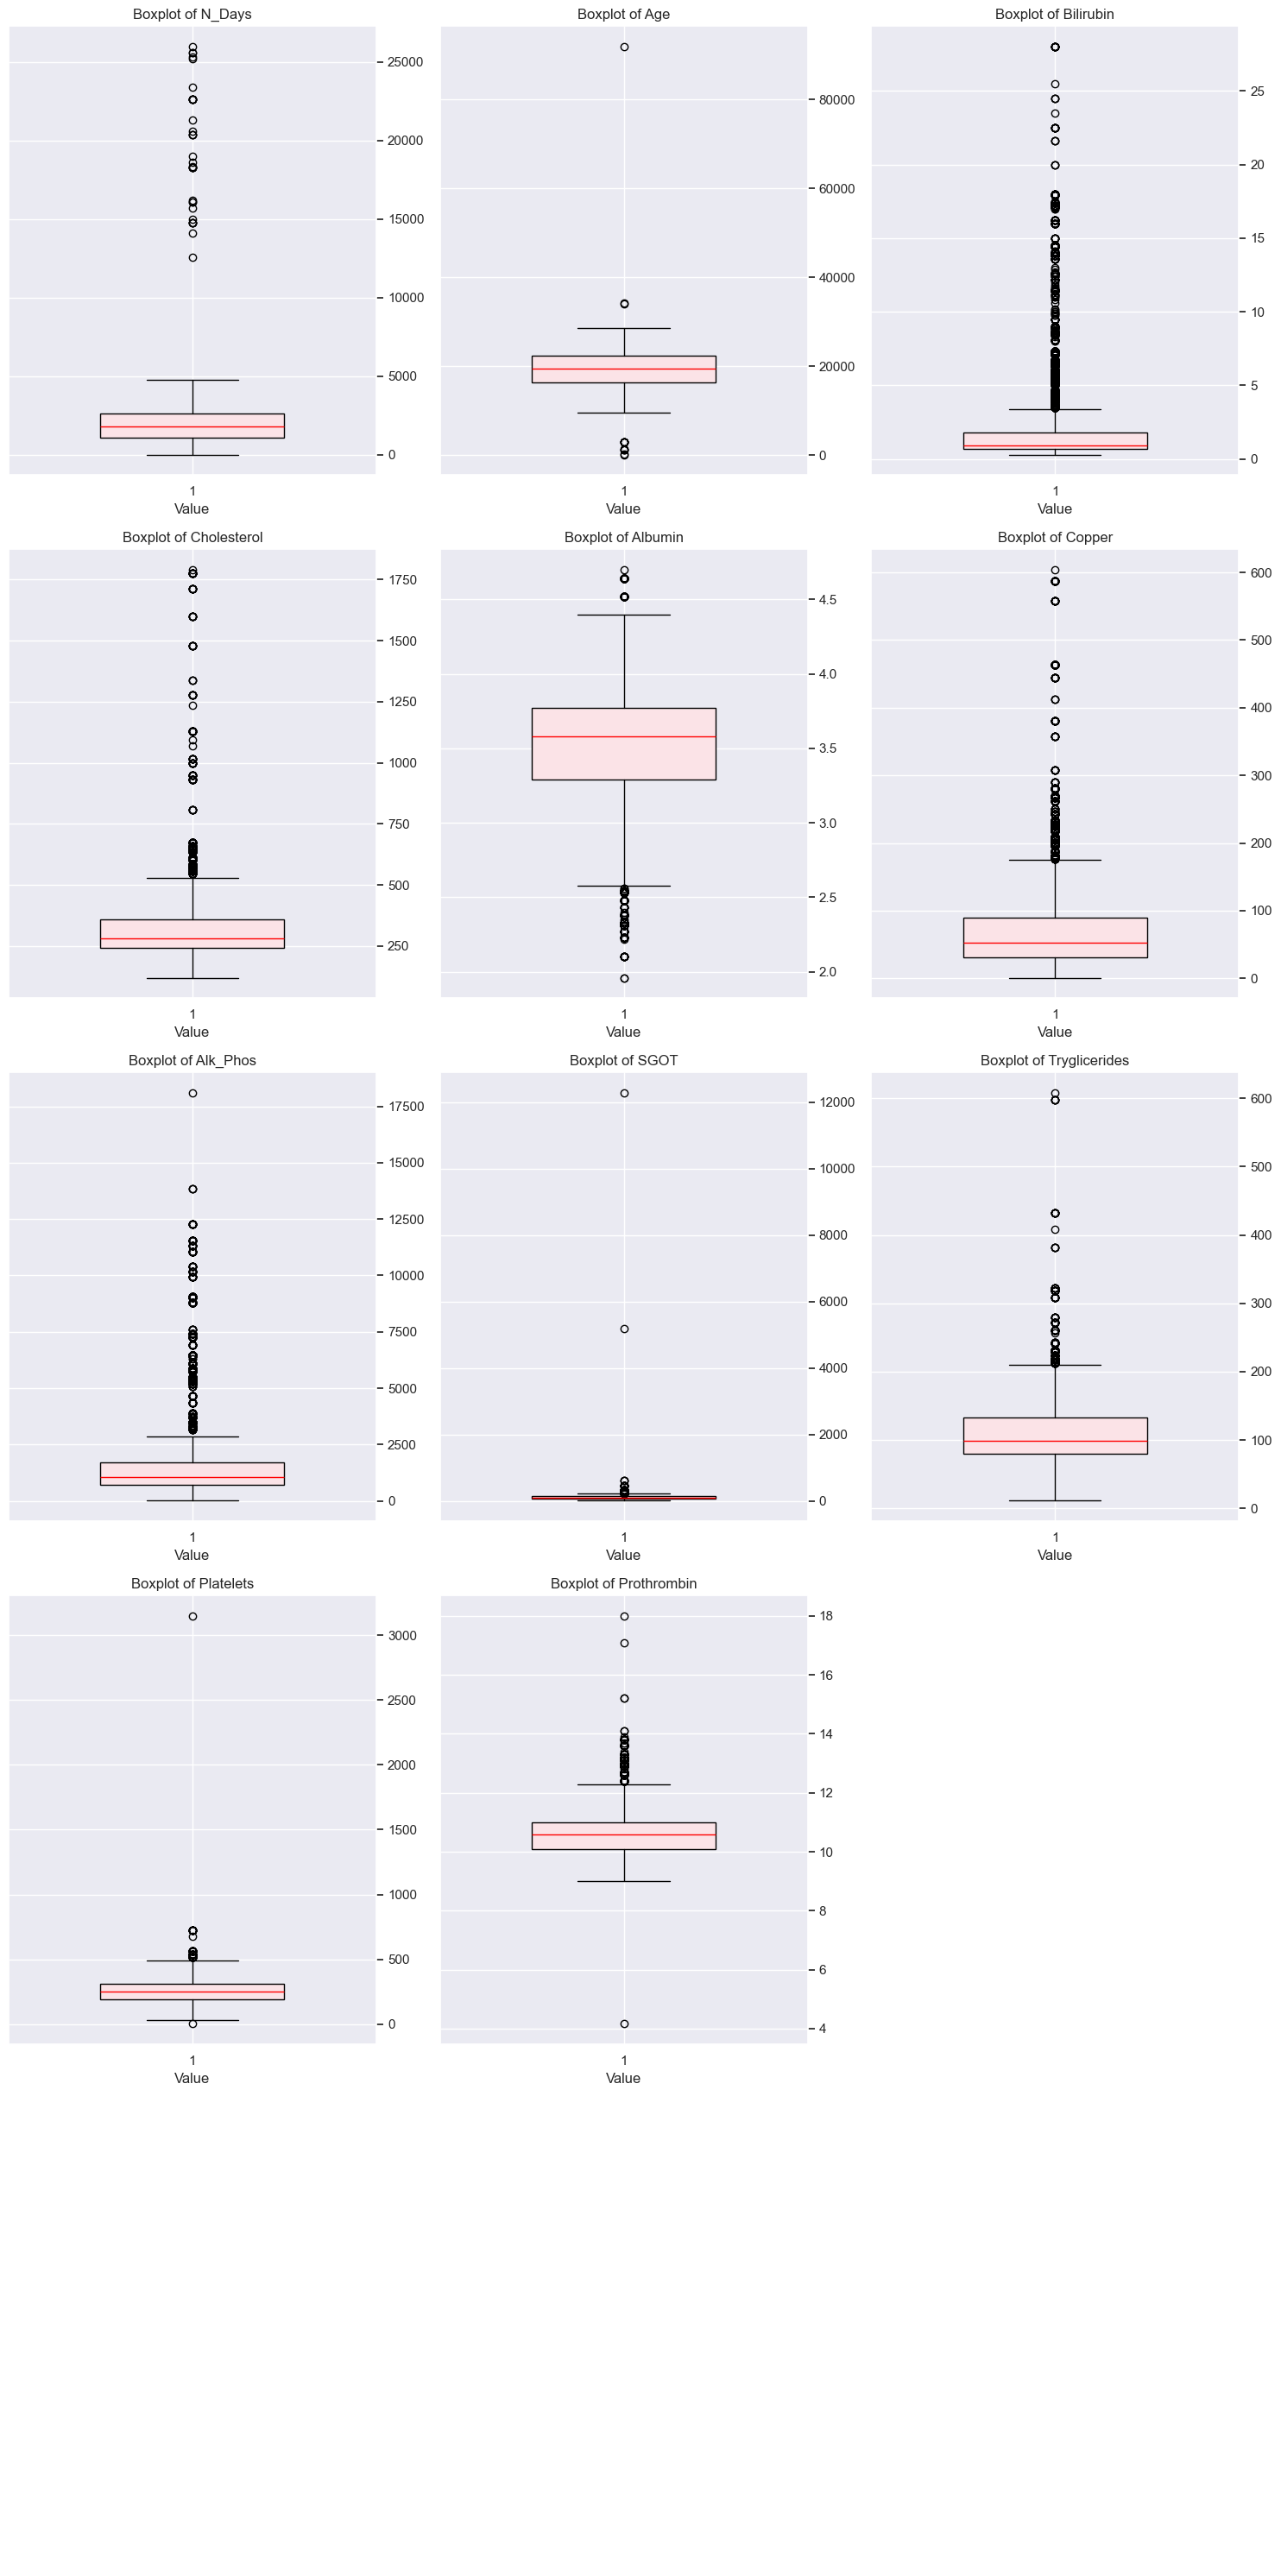

In [55]:
sns.set(style="darkgrid")

num_columns = df_numeric.columns.size
num_rows = (num_columns // 3) + (num_columns % 3)
fig, ax = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 6 * num_rows))
ax = ax.flatten()

for i, column in enumerate(df_numeric.columns):
    ax[i].boxplot(df_numeric[column].dropna(), vert=True, widths=0.5, patch_artist=True,
                    boxprops=dict(facecolor='#fbe3e7', color='black'), medianprops=dict(color='red'))
    ax[i].set_title(f'Boxplot of {column}')
    ax[i].set_xlabel('Value')
    ax[i].yaxis.tick_right()

for j in range(i + 1, len(ax)):
    ax[j].axis('off')

plt.tight_layout()
plt.show()

In [56]:
# CORRELATION
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))

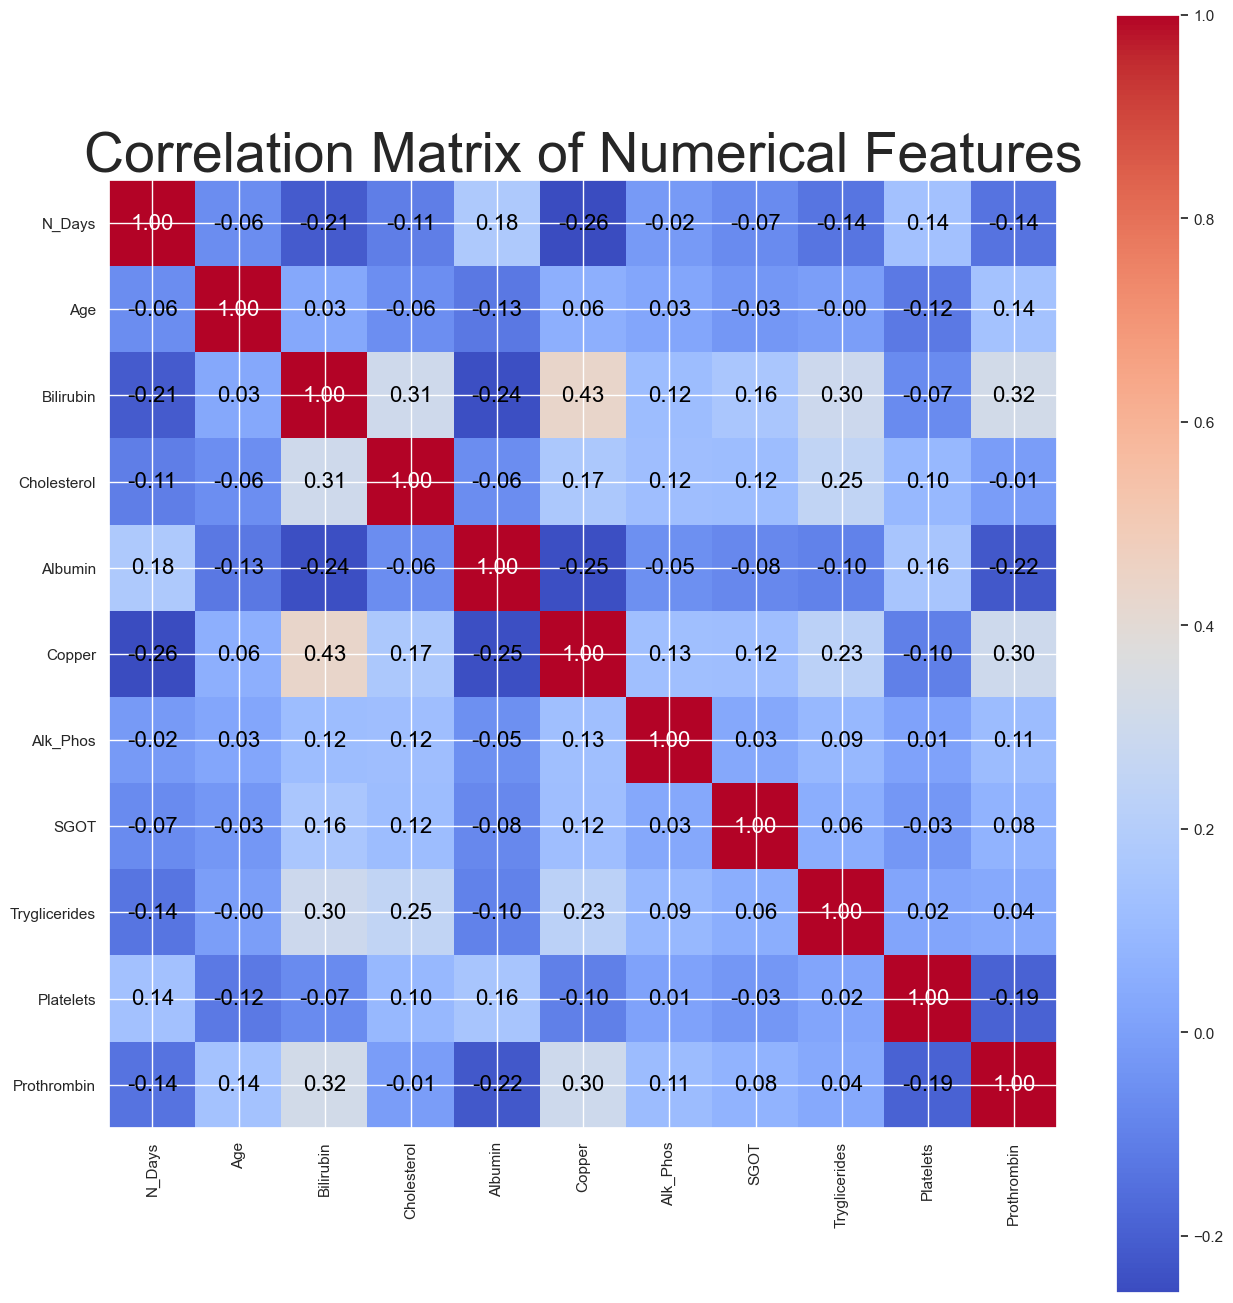

In [57]:
# NUMERICAL DATA
correlation_matrix = df_numeric.corr()

fig, ax = plt.subplots(figsize=(len(correlation_matrix.columns)*1.2, len(correlation_matrix.columns)*1.2))

cax = ax.imshow(correlation_matrix, interpolation='nearest', cmap='coolwarm')
fig.colorbar(cax)

ax.set_xticks(np.arange(len(correlation_matrix.columns)))
ax.set_yticks(np.arange(len(correlation_matrix.columns)))
ax.set_xticklabels(correlation_matrix.columns, rotation=90)
ax.set_yticklabels(correlation_matrix.columns)

for (i, j), val in np.ndenumerate(correlation_matrix):
    ax.text(j, i, f"{val:.2f}", ha='center', va='center', color='white' if abs(val) > 0.5 else 'black', fontsize=16)

plt.title('Correlation Matrix of Numerical Features', fontsize=40)
plt.tight_layout()
plt.show()

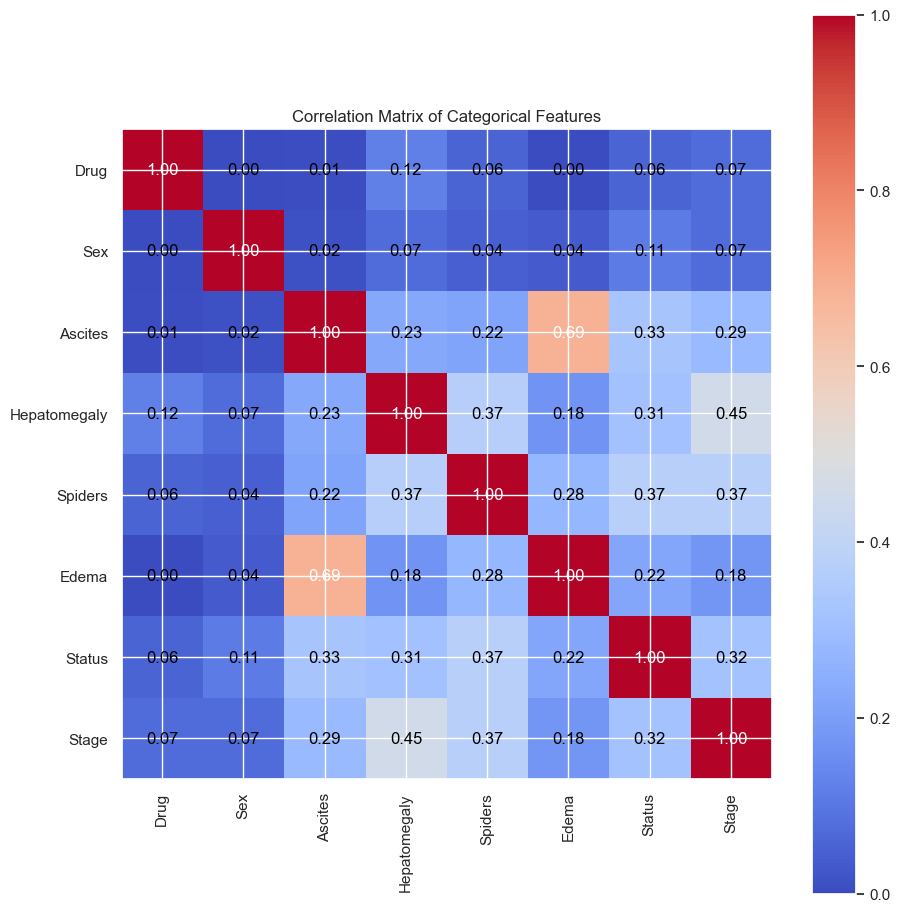

In [58]:
# CATEGORICAL DATA
cat_columns = train[categorical_data].columns
cramers = {col: {col2: cramers_v(train[col], train[col2]) for col2 in cat_columns} for col in cat_columns}
cramers_v_matrix = pd.DataFrame(cramers)

fig, ax = plt.subplots(figsize=(len(cramers_v_matrix.columns)*1.2, len(cramers_v_matrix.columns)*1.2))
cax = ax.imshow(cramers_v_matrix, interpolation='nearest', cmap='coolwarm')
fig.colorbar(cax)

ax.set_xticks(np.arange(len(cramers_v_matrix.columns)))
ax.set_yticks(np.arange(len(cramers_v_matrix.columns)))
ax.set_xticklabels(cramers_v_matrix.columns, rotation=90)
ax.set_yticklabels(cramers_v_matrix.columns)

for (i, j), val in np.ndenumerate(cramers_v_matrix):
    ax.text(j, i, f"{val:.2f}", ha='center', va='center', color='white' if abs(val) > 0.5 else 'black', fontsize=12)

plt.title('Correlation Matrix of Categorical Features')
plt.tight_layout()
plt.show()

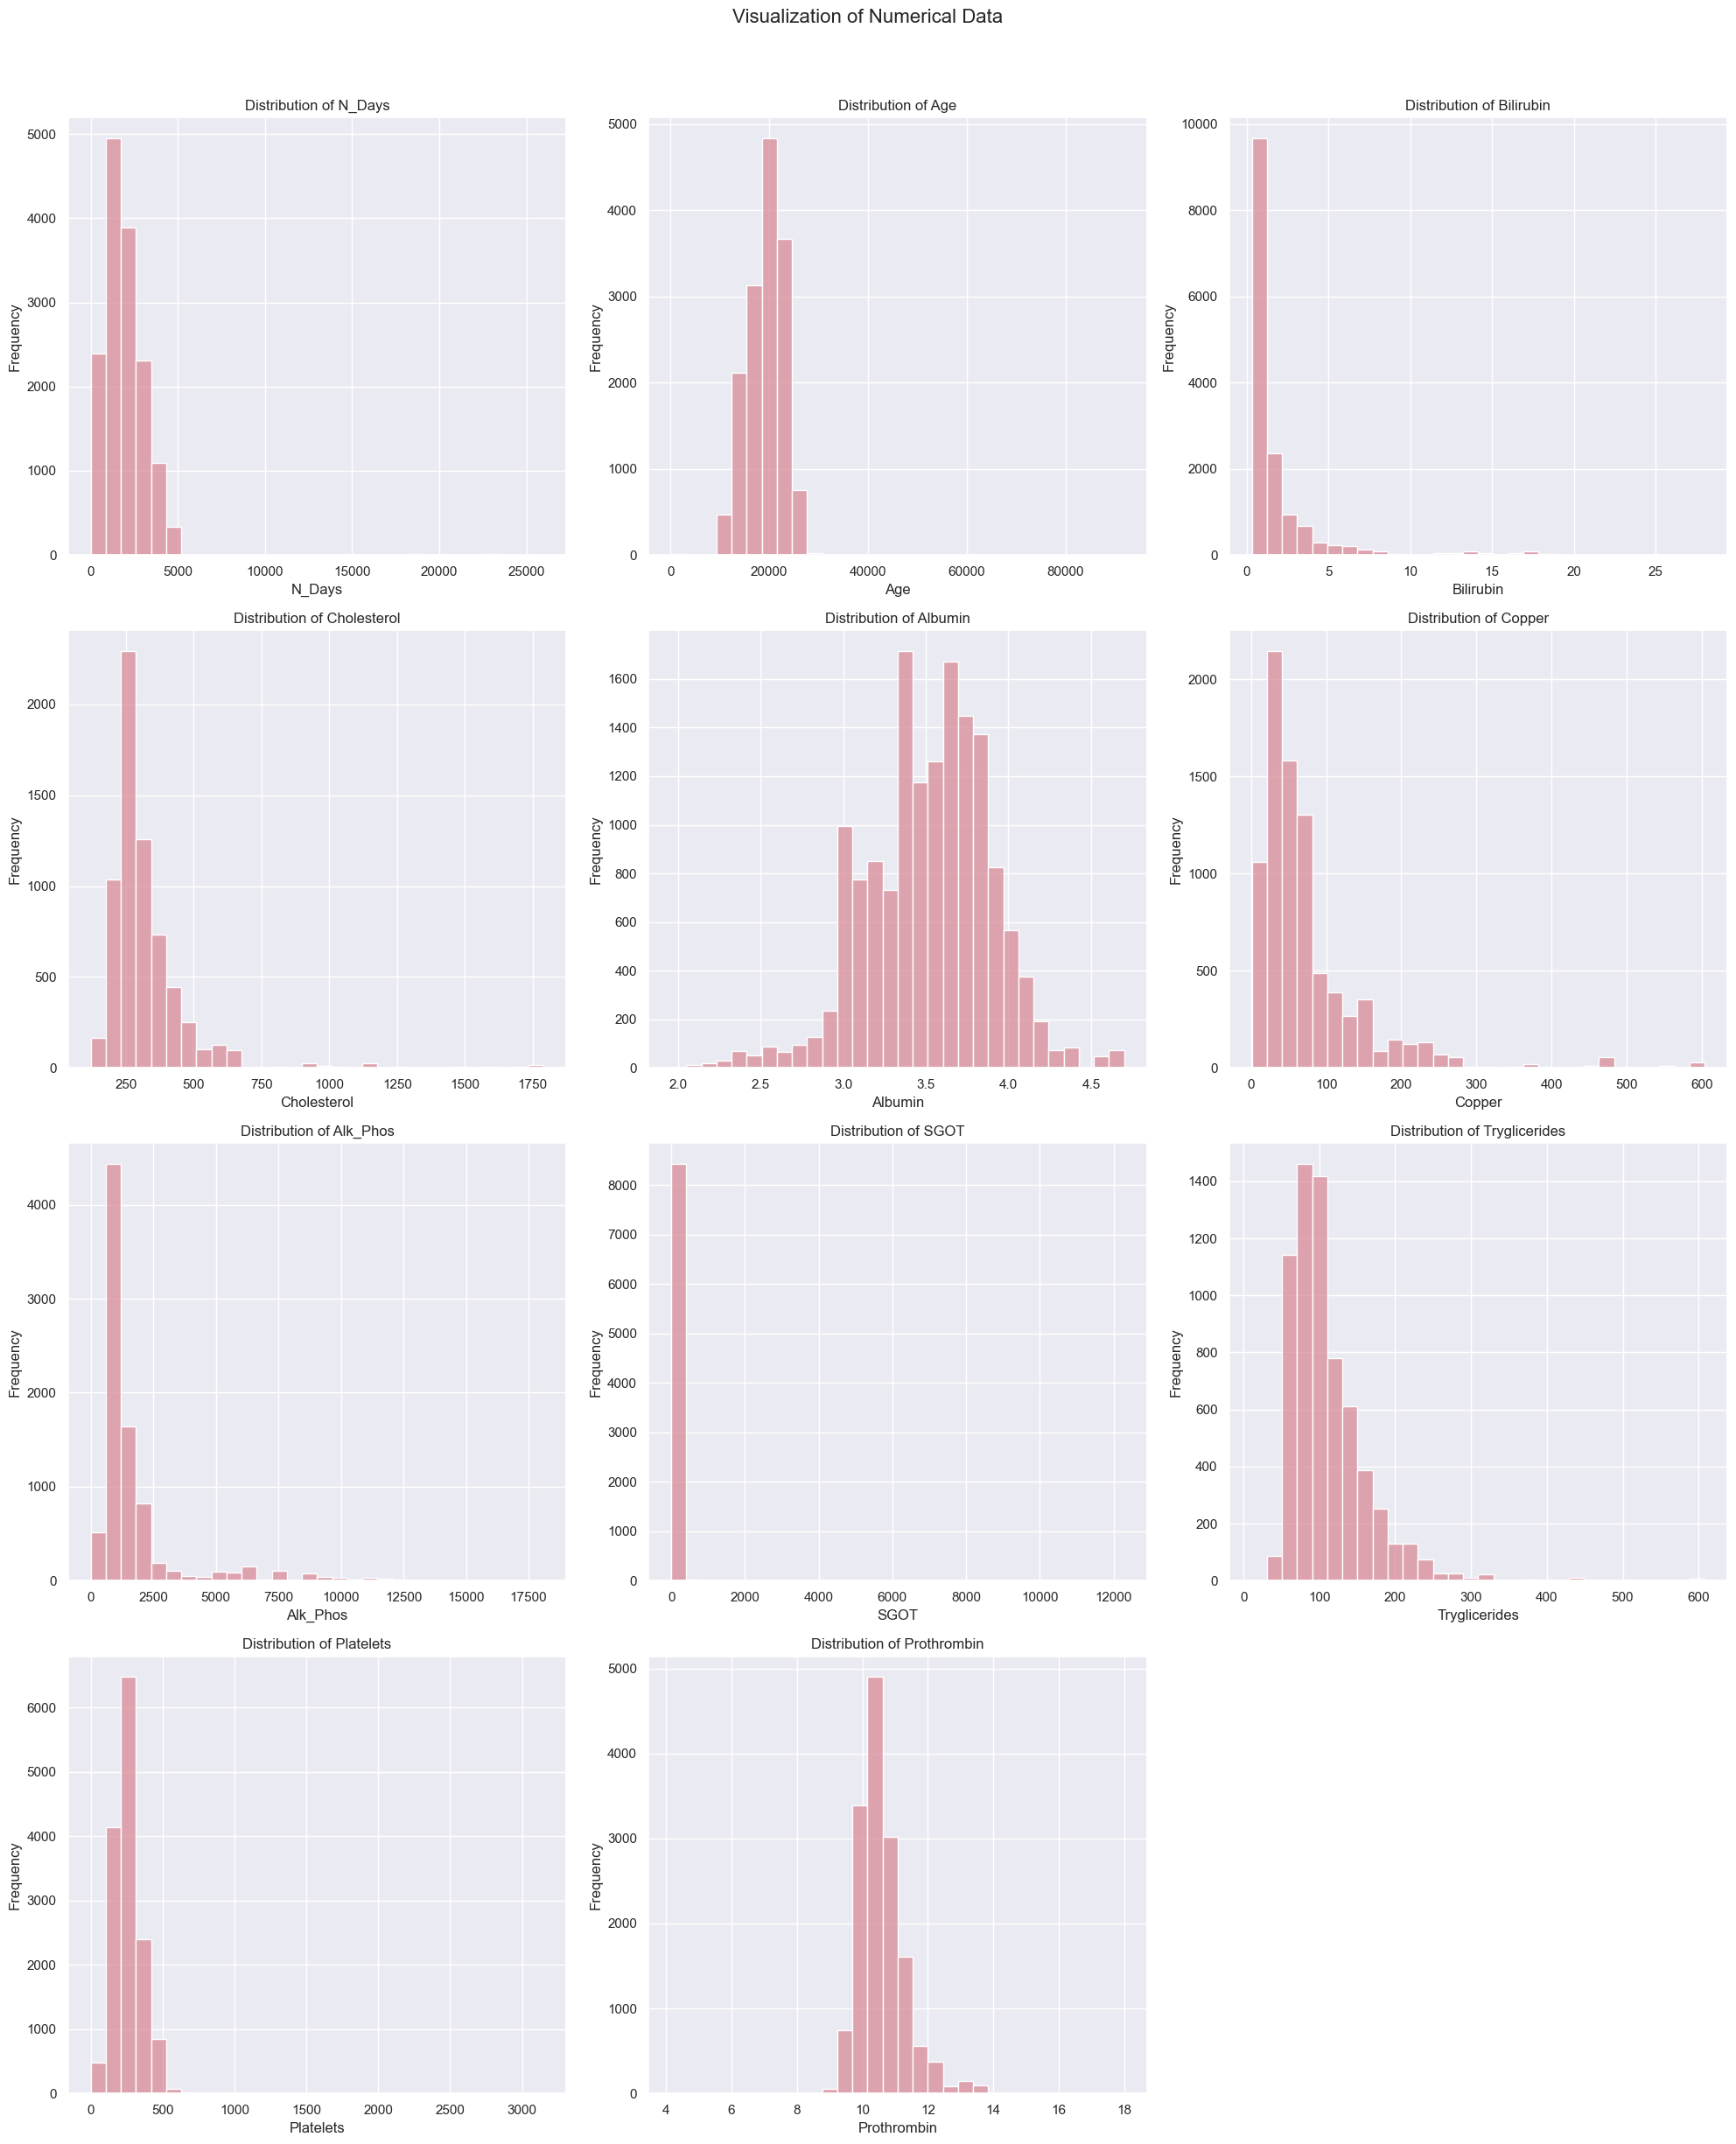

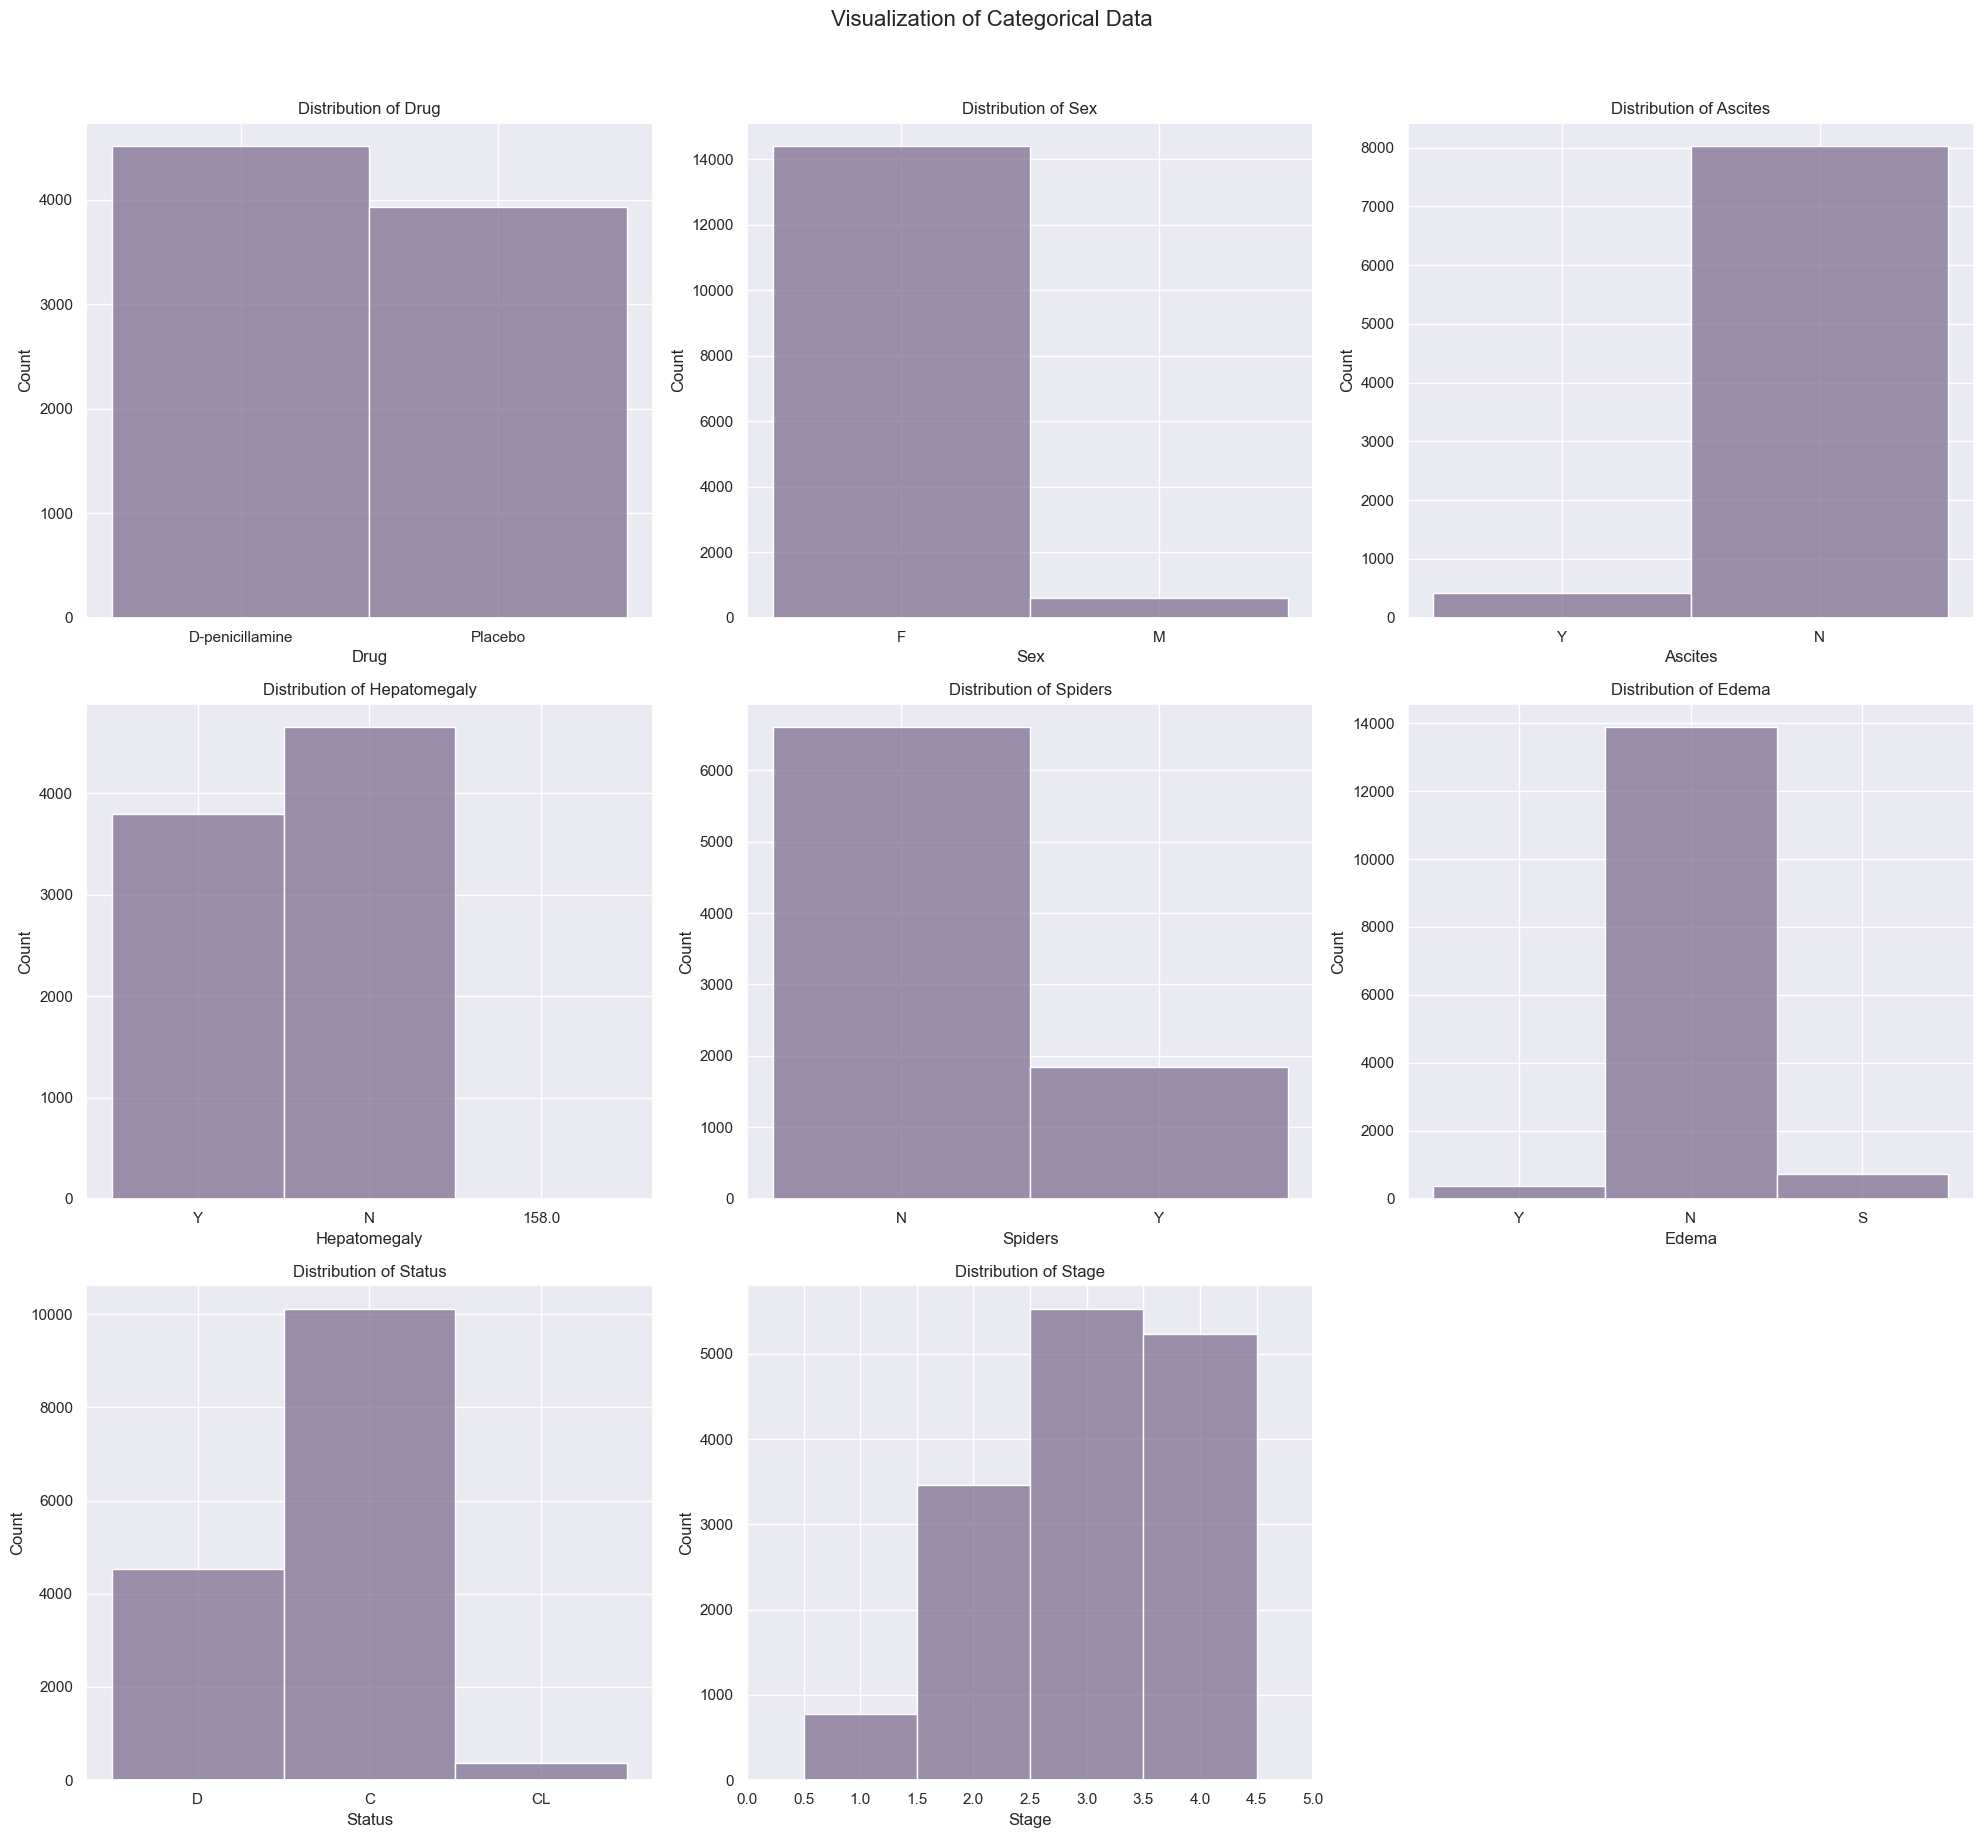

In [59]:
num_columns = 3
num_numerical_cols = len(numerical_data)
num_rows_numerical = math.ceil(num_numerical_cols / num_columns)
fig, axes = plt.subplots(num_rows_numerical, num_columns, figsize=(20, 6 * num_rows_numerical))

# Numerical Data Plotting
for i, col in enumerate(numerical_data):
    ax = axes.flatten()[i]
    sns.histplot(train[col], bins=30, color='#d88b98', kde=False, ax=ax)
    ax.set_title(f'Distribution of {col}', fontsize=12)
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

for ax in axes.flatten()[num_numerical_cols:]:
    ax.set_visible(False)

fig.suptitle('Visualization of Numerical Data', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Categorical Data Plotting
num_categorical_cols = len(categorical_data)
num_categorical_rows = math.ceil(num_categorical_cols / num_columns)
fig, axes = plt.subplots(num_categorical_rows, num_columns, figsize=(20, 6 * num_categorical_rows))

for i, col in enumerate(categorical_data):
    ax = axes.flatten()[i]
    sns.histplot(data=train, x=col, discrete=True, color='#7e6e92', ax=ax)
    ax.set_title(f'Distribution of {col}', fontsize=12)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels([tick.get_text() for tick in ax.get_xticklabels()], rotation=0)
    ax.set_xlabel(col)
    ax.set_ylabel('Count')

for ax in axes.flatten()[num_categorical_cols:]:
    ax.set_visible(False)

fig.suptitle('Visualization of Categorical Data', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

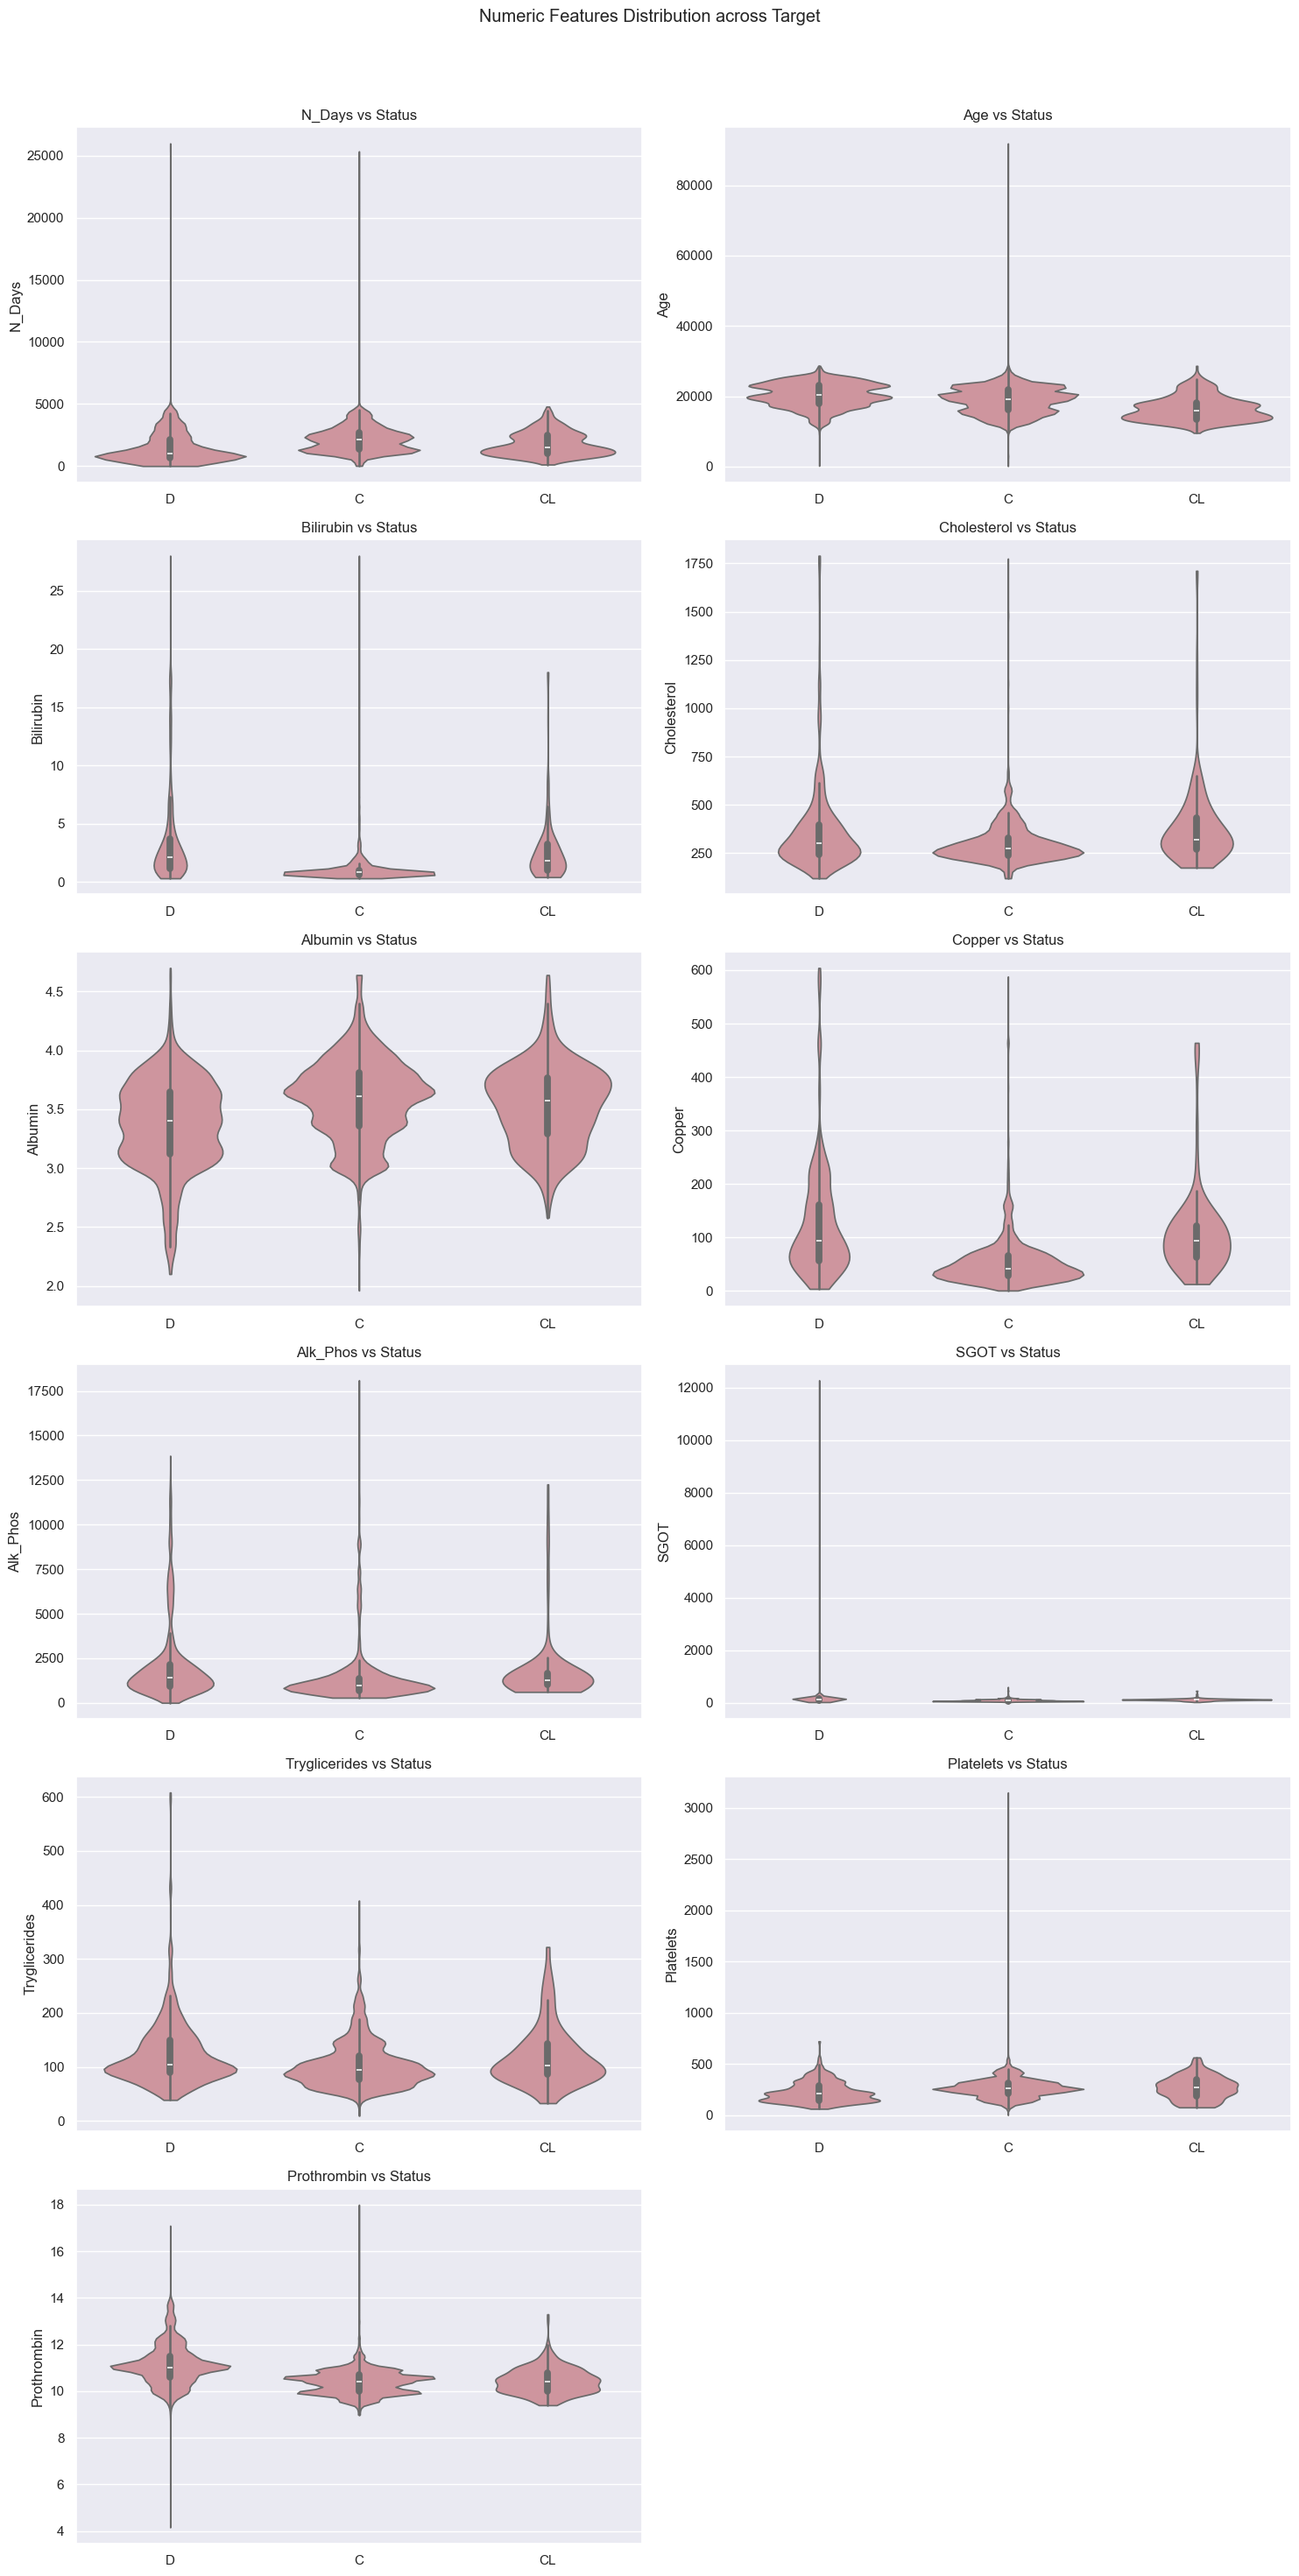

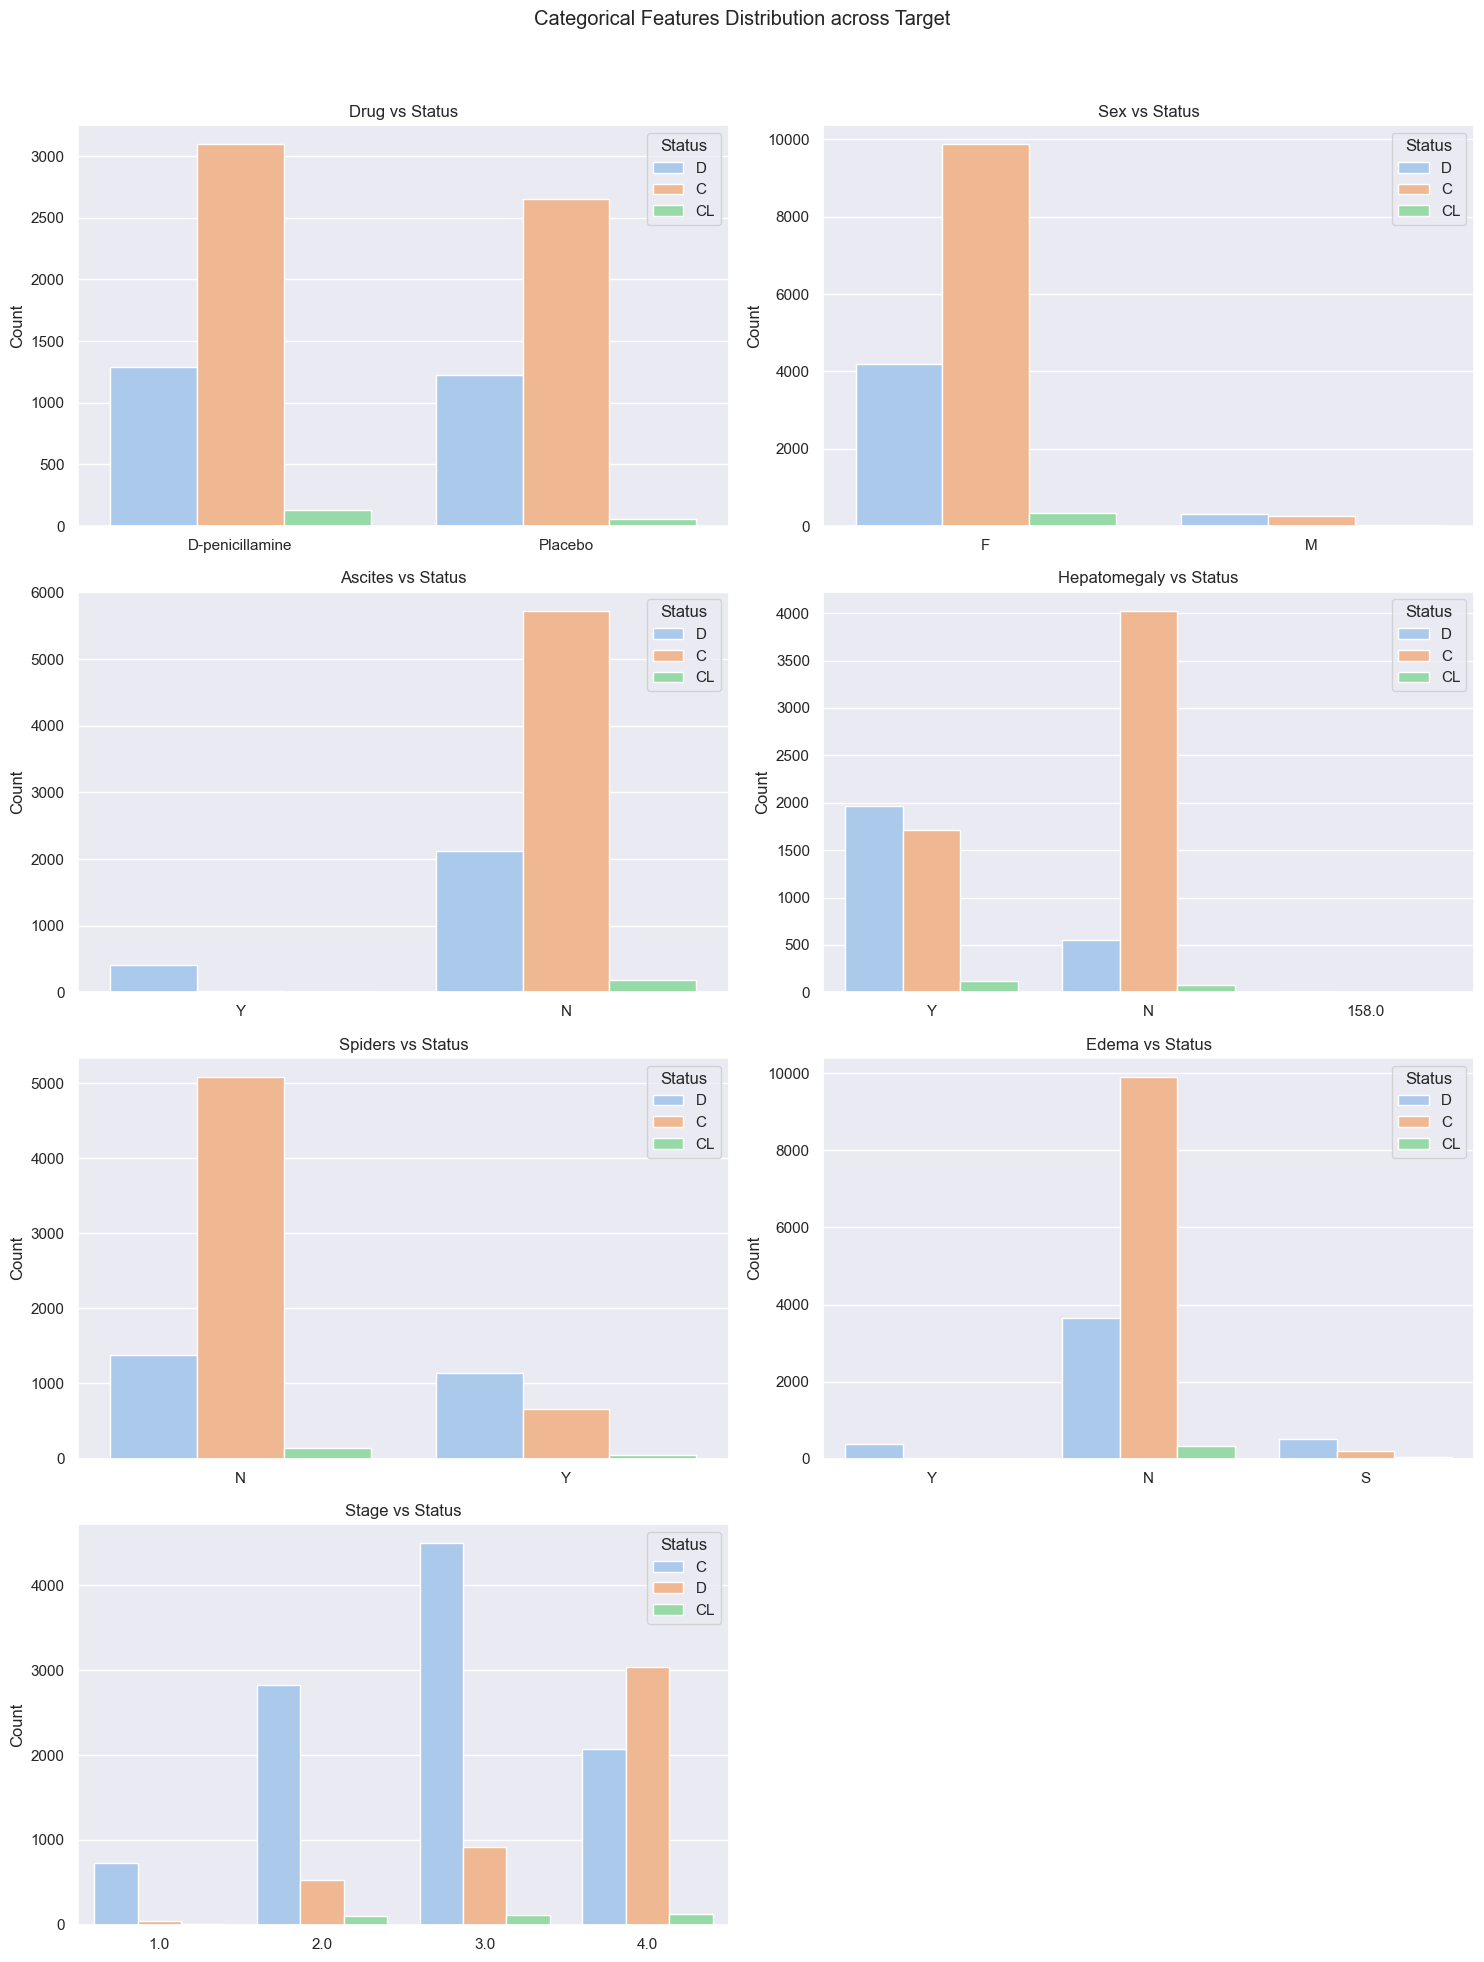

In [60]:
target = 'Status'

numerical_data = [feat for feat in numerical_data if feat != target]
categorical_data = [feat for feat in categorical_data if feat != target]

# Numerical Data Plot
num_columns = 2
num_rows_numeric = math.ceil(len(numerical_data) / num_columns)
fig, axes = plt.subplots(num_rows_numeric, num_columns, figsize=(15, 5 * num_rows_numeric), squeeze=False)
fig.suptitle('Numeric Features Distribution across Target')

idx = 0
for feature in numerical_data:
    ax = axes[idx // num_columns, idx % num_columns]
    sns.violinplot(ax=ax, x=target, y=feature, data=train, cut=0, color='#d88b98')
    ax.set_title(f'{feature} vs {target}')
    ax.set_xlabel('')
    ax.set_ylabel(feature)
    idx += 1

# Hide empty subplots if any
for i in range(idx, num_rows_numeric * num_columns):
    axes[i // num_columns, i % num_columns].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Categorical Data Plot
num_rows_categorical = math.ceil(len(categorical_data) / num_columns)
fig, axes = plt.subplots(num_rows_categorical, num_columns, figsize=(15, 5 * num_rows_categorical), squeeze=False)
fig.suptitle('Categorical Features Distribution across Target')

idx = 0
for feature in categorical_data:
    ax = axes[idx // num_columns, idx % num_columns]
    sns.countplot(ax=ax, x=feature, hue=target, data=train, palette="pastel")
    ax.set_title(f'{feature} vs {target}')
    ax.set_xlabel('')
    ax.set_ylabel('Count')
    ax.legend(title=target, loc='upper right')
    idx += 1

for i in range(idx, num_rows_categorical * num_columns):
    axes[i // num_columns, i % num_columns].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# 2. Split Training Set and Validation Set

Splitting the training and validation set works as an early diagnostic towards the performance of the model we train. This is done before the preprocessing steps to **avoid data leakage inbetween the sets**. If you want to use k-fold cross-validation, split the data later and do the cleaning and preprocessing separately for each split.

Note: For training, you should use the data contained in the `train.csv` given by the TA. The `test.csv` data is only used for kaggle submission.

In [61]:
def check_distribution(y_data, set_name):
    dist = y_data.value_counts(normalize=True)
    print(f"\nClass distribution in {set_name} set:")
    print(dist)

target_col = ['Status']
cat_columns = train.select_dtypes(include=['object']).columns.tolist()
cat_columns.append('Stage')
indices_to_drop = [i for i, val in enumerate(cat_columns) if val in target_col]
cat_columns = np.delete(cat_columns, indices_to_drop)
num_columns = train.select_dtypes(include=['int64', 'float64']).columns.tolist()   
num_columns.remove('Stage')

# split data
x_train = train.drop(target_col, axis=1)
y_train = train[target_col]

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

print(f"Training Set Size: {x_train.shape}, Validation Set Size: {x_val.shape}")

# check_distribution(y, "original")
check_distribution(y_train, "training")
check_distribution(y_val, "validation")

# Save the splits
x_train.to_csv('X_train_bootstrap.csv', index=False)
y_train.to_csv('y_train_bootstrap.csv', index=False)
x_val.to_csv('X_val.csv', index=False)
y_val.to_csv('y_val.csv', index=False)

Training Set Size: (12000, 19), Validation Set Size: (3000, 19)

Class distribution in training set:
Status
C         0.674500
D         0.301667
CL        0.023833
Name: proportion, dtype: float64

Class distribution in validation set:
Status
C         0.674333
D         0.301667
CL        0.024000
Name: proportion, dtype: float64


# 3. Data Cleaning and Preprocessing

This step is the first thing to be done once a Data Scientist have grasped a general knowledge of the data. Raw data is **seldom ready for training**, therefore steps need to be taken to clean and format the data for the Machine Learning model to interpret.

By performing data cleaning and preprocessing, you ensure that your dataset is ready for model training, leading to more accurate and reliable machine learning results. These steps are essential for transforming raw data into a format that machine learning algorithms can effectively learn from and make predictions.

For each step that you will do, **please explain the reason why did you do that process. Write it in a markdown cell under the code cell you wrote.**

In [62]:
# check for missing values
missing_train = train.isnull().sum()
missing_test = test.isnull().sum()

print("missing values in train data:")
print(missing_train[missing_train > 0])

# percentage
for column in missing_train[missing_train > 0].index:
    print(f"{column}: {missing_train[column] / train.shape[0] * 100:.2f}%")

print("\nmissing values in test data:")
print(missing_test[missing_test > 0])

missing values in train data:
Drug             6550
Ascites          6547
Hepatomegaly     6552
Spiders          6559
Cholesterol      8374
Copper           6660
Alk_Phos         6556
SGOT             6559
Tryglicerides    8425
Platelets         584
Prothrombin        16
dtype: int64
Drug: 43.67%
Ascites: 43.65%
Hepatomegaly: 43.68%
Spiders: 43.73%
Cholesterol: 55.83%
Copper: 44.40%
Alk_Phos: 43.71%
SGOT: 43.73%
Tryglicerides: 56.17%
Platelets: 3.89%
Prothrombin: 0.11%

missing values in test data:
N_Days              1
Drug             4368
Ascites          4365
Hepatomegaly     4372
Spiders          4373
Cholesterol      5625
Copper           4440
Alk_Phos         4374
SGOT             4374
Tryglicerides    5657
Platelets         390
Prothrombin        10
dtype: int64


In [63]:
print("categorical features:")
print(cat_columns)

print("\nnumerical features:")
print(num_columns)


categorical features:
['Drug' 'Sex' 'Ascites' 'Hepatomegaly' 'Spiders' 'Edema' 'Stage']

numerical features:
['id', 'N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']


In [64]:
# check unique values in categorical features
for col in cat_columns:
    print(f"unique values in {col}:")
    print(train[col].value_counts())
    print()

unique values in Drug:
Drug
D-penicillamine    4515
Placebo            3935
Name: count, dtype: int64

unique values in Sex:
Sex
F    14405
M      595
Name: count, dtype: int64

unique values in Ascites:
Ascites
N    8027
Y     426
Name: count, dtype: int64

unique values in Hepatomegaly:
Hepatomegaly
N        4652
Y        3795
158.0       1
Name: count, dtype: int64

unique values in Spiders:
Spiders
N    6598
Y    1843
Name: count, dtype: int64

unique values in Edema:
Edema
N    13874
S      737
Y      389
Name: count, dtype: int64

unique values in Stage:
Stage
3.0    5530
4.0    5235
2.0    3456
1.0     779
Name: count, dtype: int64



In [65]:
# check for skewness
print("Skewness of each column in numerical:")
for column in num_columns:
    print(column, ":", train[column].skew())

Skewness of each column in numerical:
id : 0.0
N_Days : 5.723226588086048
Age : 0.2501326957918793
Bilirubin : 4.228548344977254
Cholesterol : 4.499543223972586
Albumin : -0.30018987991930035
Copper : 3.115699180745672
Alk_Phos : 3.1538951588374986
SGOT : 65.28128415449646
Tryglicerides : 2.368980642200841
Platelets : 2.340967199225039
Prothrombin : 1.2436597583866906


In [66]:
# handle outliers using clipping
df_numeric = train[numerical_data]

# compute IQR
Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1

# define boundaries for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# outlier clipping
num_train_clipped = df_numeric.copy()  # Create a copy to apply clipping
num_train_clipped = num_train_clipped.clip(lower=lower_bound, upper=upper_bound, axis=1)

# display results
print("\n----- NUMERICAL DATA OUTLIERS BY IQR (AFTER CLIPPING) -----")
outliers_iqr_after_clipping = (num_train_clipped < lower_bound) | (num_train_clipped > upper_bound)
display(outliers_iqr_after_clipping.any())

print("\n----- JUMLAH OUTLIER PER KOLOM NUMERICAL (AFTER CLIPPING) -----")
outliers_count_per_column_after_clipping = outliers_iqr_after_clipping.sum()
display(outliers_count_per_column_after_clipping)


----- NUMERICAL DATA OUTLIERS BY IQR (AFTER CLIPPING) -----


N_Days           False
Age              False
Bilirubin        False
Cholesterol      False
Albumin          False
Copper           False
Alk_Phos         False
SGOT             False
Tryglicerides    False
Platelets        False
Prothrombin      False
dtype: bool


----- JUMLAH OUTLIER PER KOLOM NUMERICAL (AFTER CLIPPING) -----


N_Days           0
Age              0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
dtype: int64

In [67]:
def check_distribution(y_data, set_name):
    dist = y_data.value_counts(normalize=True)
    print(f"\nClass distribution in {set_name} set:")
    print(dist)

target_col = ['Status']
cat_columns = train.select_dtypes(include=['object']).columns.tolist()
indices_to_drop = [i for i, val in enumerate(cat_columns) if val in target_col]
cat_columns = np.delete(cat_columns, indices_to_drop)
num_columns = num_train_clipped.select_dtypes(include=['int64', 'float64']).columns.tolist()   

# change train[numerical_data] to num_train_clipped
train[num_columns] = num_train_clipped

# split data
x_train = train.drop(target_col, axis=1)
y_train = train[target_col]

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

print(f"Training Set Size: {x_train.shape}, Validation Set Size: {x_val.shape}")

# check_distribution(y, "original")
check_distribution(y_train, "training")
check_distribution(y_val, "validation")

# save splits
# x_train.to_csv('X_train_bootstrap.csv', index=False)
# y_train.to_csv('y_train_bootstrap.csv', index=False)
# x_val.to_csv('X_val.csv', index=False)
# y_val.to_csv('y_val.csv', index=False)

Training Set Size: (12000, 19), Validation Set Size: (3000, 19)

Class distribution in training set:
Status
C         0.674500
D         0.301667
CL        0.023833
Name: proportion, dtype: float64

Class distribution in validation set:
Status
C         0.674333
D         0.301667
CL        0.024000
Name: proportion, dtype: float64


In [68]:
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # fill missing values with the mean
    ('scaler', StandardScaler())  # standardize features
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # fill missing values with the mode
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # one-hot encode categorical variables
])

# 3. Compile Preprocessing Pipeline

All of the preprocessing classes or functions defined earlier will be compiled in this step.

If you use sklearn to create preprocessing classes, you can list your preprocessing classes in the Pipeline object sequentially, and then fit and transform your data.

In [69]:
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, num_columns),
    ('cat', categorical_pipeline, cat_columns)
])

In [70]:
X_train_processed = preprocessor.fit_transform(x_train)
X_val_processed = preprocessor.transform(x_val)

# 4. Modeling and Validation

Modelling is the process of building your own machine learning models to solve specific problems, or in this assignment context, predicting the probability for each class in the `Status` feature (`Status_C`, `Status_CL`, `Status_D`). Validation is the process of evaluating your trained model using the validation set or cross-validation method and providing some metrics that can help you decide what to do in the next iteration of development.

## KNN

In [71]:
knn_model = KNeighborsClassifier()

# train the model
knn_model.fit(X_train_processed, y_train)

# predict probabilities on the validation set
y_val_pred_knn = knn_model.predict_proba(X_val_processed)

# calculate log loss
knn_log_loss = log_loss(y_val, y_val_pred_knn)

print(f"KNN Log Loss: {knn_log_loss:.4f}")


KNN Log Loss: 2.0756


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


## Naive Bayes

In [72]:
nb_model = GaussianNB()

# train the model
nb_model.fit(X_train_processed, y_train)

# predict probabilities on the validation set
y_val_pred_nb = nb_model.predict_proba(X_val_processed)

# calculate log loss
nb_log_loss = log_loss(y_val, y_val_pred_nb)

print(f"Naive Bayes Log Loss: {nb_log_loss:.4f}")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Naive Bayes Log Loss: 15.6834


## ID3

In [73]:
dt_model = DecisionTreeClassifier(random_state=42)

# train the model
dt_model.fit(X_train_processed, y_train)

# predict probabilities on the validation set
y_val_pred_dt = dt_model.predict_proba(X_val_processed)

# calculate log loss
dt_log_loss = log_loss(y_val, y_val_pred_dt)

print(f"Decision Tree Log Loss: {dt_log_loss:.4f}")

Decision Tree Log Loss: 7.7138


## SVM

In [74]:
svm_model = SVC(probability=True, random_state=42)

# train the model
svm_model.fit(X_train_processed, y_train)

# predict probabilities on the validation set
y_val_pred_svm = svm_model.predict_proba(X_val_processed)

# calculate log loss
svm_log_loss = log_loss(y_val, y_val_pred_svm)

print(f"SVM Log Loss: {svm_log_loss:.4f}")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM Log Loss: 0.4406


## Logistic Regression

In [75]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# train the model
lr_model.fit(X_train_processed, y_train)

# predict probabilities on the validation set
y_val_pred_lr = lr_model.predict_proba(X_val_processed)

# calculate log loss
lr_log_loss = log_loss(y_val, y_val_pred_lr)

print(f"Logistic Regression Log Loss: {lr_log_loss:.4f}")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Log Loss: 0.4332


### SUMMARY

In [76]:
# log Loss results
log_loss_results = {
    'KNN': knn_log_loss,
    'Naive Bayes': nb_log_loss,
    'Decision Tree': dt_log_loss,
    'SVM': svm_log_loss,
    'Logistic Regression': lr_log_loss
}

print("Log Loss Results:")
for model, loss in log_loss_results.items():
    print(f"{model}: {loss:.4f}")

# identify the best-performing model
best_model_name = min(log_loss_results, key=log_loss_results.get)
print(f"The best model is {best_model_name} with a Log Loss of {log_loss_results[best_model_name]:.4f}")

Log Loss Results:
KNN: 2.0756
Naive Bayes: 15.6834
Decision Tree: 7.7138
SVM: 0.4406
Logistic Regression: 0.4332
The best model is Logistic Regression with a Log Loss of 0.4332


## Notes for improvements

- **Visualize the model evaluation result**

This will help you to understand the details more clearly about your model's performance. From the visualization, you can see clearly if your model is leaning towards a class than the others. (Hint: confusion matrix, ROC-AUC curve, etc.)

- **Explore the hyperparameters of your models**

Each models have their own hyperparameters. And each of the hyperparameter have different effects on the model behaviour. You can optimize the model performance by finding the good set of hyperparameters through a process called **hyperparameter tuning**. (Hint: Grid search, random search, bayesian optimization)

- **Cross-validation**

Cross-validation is a critical technique in machine learning and data science for evaluating and validating the performance of predictive models. It provides a more **robust** and **reliable** evaluation method compared to a hold-out (single train-test set) validation. Though, it requires more time and computing power because of how cross-validation works. (Hint: k-fold cross-validation, stratified k-fold cross-validation, etc.)

- **Ensemble methods**

Ensemble methods are powerful machine learning techniques that combine the predictions of multiple models (often referred to as base learners or weak learners) to create a stronger, more accurate predictive model. The idea behind ensemble methods is that by aggregating the opinions of multiple models, you can reduce the impact of individual model errors and improve overall prediction performance. (Hint: bagging, boosting, stacking, voting)

- **Model interpretation**

Model interpretation is the process of understanding and explaining the inner workings of a machine learning model, particularly its decision-making process. Interpretation helps data scientists, stakeholders, and end-users gain insights into why a model makes certain predictions or classifications. Model interpretation is crucial for building trust in machine learning systems, identifying biases, and extracting actionable information from models. (Hint: Feature importance, PDP, SHAP Values, etc)

- **Explore other models**

There are a lot of ML models that you can use in this usecase. Try to explore and use them to solve this problem.

## Submission
To predict the test set target feature and submit the results to the kaggle competition platform, do the following:
1. Create a new pipeline instance identical to the first in Data Preprocessing
2. With the pipeline, apply `fit_transform` to the original training set before splitting, then only apply `transform` to the test set.
3. Retrain the model on the preprocessed training set
4. Predict the test set
5. Make sure the submission contains the `id`, `Status_C`, `Status_CL`, `Status_D` column.

In [77]:
model_mapping = {
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
}

full_preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, num_columns),
    ('cat', categorical_pipeline, cat_columns)
])

X_full_processed = full_preprocessor.fit_transform(x_train)  # entire training set
test_processed = full_preprocessor.transform(test)  # test set

best_model = model_mapping[best_model_name]
best_model.fit(X_full_processed, y_train)

if best_model_name == 'Naive Bayes':
    test_predictions = best_model.predict_proba(test_processed)
else:
    test_predictions = best_model.predict_proba(test_processed)

# prepare the submission dataframe
submission = pd.DataFrame(test_predictions, columns=best_model.classes_)
submission['id'] = test['id']
submission = submission[['id'] + list(best_model.classes_)]  # ensure correct column order

submission.rename(columns={
    'C': 'Status_C',
    'CL': 'Status_CL',
    'D': 'Status_D'
}, inplace=True)

# save the submission file
submission.to_csv('submission.csv', index=False)

print(f"Submission file created using {best_model_name}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Submission file created using Logistic Regression


# 6. Error Analysis

Based on all the process you have done until the modeling and evaluation step, write an analysis to support each steps you have taken to solve this problem. Write the analysis using the markdown block. Some questions that may help you in writing the analysis:

- Does my model perform better in predicting one class than the other? If so, why is that?
- To each models I have tried, which performs the best and what could be the reason?
- Is it better for me to impute or drop the missing data? Why?
- Does feature scaling help improve my model performance?
- etc...

`Provide your analysis here`